## TODO

* Table containing accuracy, precision, specificity, recall, f1, roc-auc for best classifier configurations
* Roc-auc graphs for each best classifier configuration
* Table of accuracy, precision, specificity, and percent uncertainty at each threshold
* Graphs of accuracy, precision, specificity, and percent uncertainty at each threshold
* Some kind of graph/table using empath (top categories at each threshold?)


In [33]:
import json
import yaml
import importlib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, average_precision_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from scipy.sparse import load_npz

from functools import partial

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

In [2]:
MODEL_BINARY_PATH = '../models/best_models_w2v_rating_2021-05-29.pickle'

with open(MODEL_BINARY_PATH, 'rb') as filestream:
    d = pickle.load(filestream)

In [7]:
MODEL_BINARY_PATH = '../models/best_models_w2v_rating_SVC_2021-06-03.pickle'

with open(MODEL_BINARY_PATH, 'rb') as filestream:
    d_svc = pickle.load(filestream)

In [8]:
METRICS = {
    'accuracy':accuracy_score,
    'precision':partial(precision_score),
    'negative predictive value':partial(precision_score,pos_label = -1),
    'recall':recall_score,
    'f1':f1_score,
    #'average_precision':average_precision_score,
    'roc_auc':roc_auc_score
}

def generate_sample(df,n,balance=True):
    if balance and n:
        pos = df.loc[df['aft_net_sign_helpful'] > 0].sample(int(n/2))
        neg = df.loc[df['aft_net_sign_helpful'] < 0].sample(int(n/2))
        sample = pos.append(neg)
    elif n:
        sample = df.loc[df['aft_net_sign_helpful'] != 0].sample(n)
    else:
        sample = df.loc[df['aft_net_sign_helpful'] != 0]
    return sample

def proba_to_preds(probability_list,threshold=.5):
    preds = []
    for proba in probability_list:
        if proba[1] > threshold:
            preds.append(1)
        else:
            preds.append(-1)
    return preds

def results_to_table(proba,truth):
    result_dict = results_to_json(proba,truth)
    return pd.DataFrame([result_dict])
    #return results

def results_to_json(proba,truth):
    preds = proba_to_preds(proba)
    results_dict = {}
    for metric in METRICS:
        if metric == 'roc_auc':
            results_dict[metric] = METRICS[metric](truth,proba[:, 1])
        else:
            results_dict[metric] = METRICS[metric](truth,preds)
    return results_dict

In [93]:
feature_path_w2v = '../datasets/vectorized/vectorized_w2v_rating_2021-03-31.json'

def load_dataset(feature_path,sparse_matrix_path=None):
    with open(feature_path,'r') as filestream:
        df = pd.DataFrame(json.load(filestream))

    df = generate_sample(df, None)
    df = df.reset_index()
    
    if sparse_matrix_path:
        with open(sparse_matrix_path,'rb') as filestream:
            features = load_npz(filestream)
            
    else:
        features = pd.DataFrame(df['feature_vector'].values.tolist()).to_numpy()

    labels = df['aft_net_sign_helpful'].to_numpy()
    
    return features, labels, df

features, labels, df = load_dataset(feature_path_w2v)

In [10]:
labels_train = labels[d['indices']['train']]
labels_test = labels[d['indices']['test']]
features_train = features[d['indices']['train']]
features_test = features[d['indices']['test']]

In [ ]:
del d['classifiers']['SVC']

for c in d_svc['classifiers']:
    d['classifiers'][c] = d_svc['classifiers'][c]

In [19]:
d

{'classifiers': {'GradientBoostingClassifier': GridSearchCV(estimator=Pipeline(steps=[('clf', DummyEstimator())]), n_jobs=32,
               param_grid=[{'clf': [GradientBoostingClassifier(learning_rate=0.01,
                                                               max_depth=7,
                                                               max_features='log2',
                                                               min_samples_leaf=13,
                                                               n_estimators=700)],
                            'clf__learning_rate': [0.01, 0.1, 0.5, 1],
                            'clf__max_depth': [1, 3, 5, 7],
                            'clf__max_features': ['log2'],
                            'clf__min_samples_leaf': [1, 3, 5, 7, 13],
                            'clf__n_estimators': [100, 300, 500, 700]}],
               pre_dispatch=64, refit='roc_auc',
               scoring=('roc_auc', 'f1', 'accuracy', 'recall', 'precision')),
  '

In [98]:
d['classifiers']['LogisticRegression'].bes

GridSearchCV(estimator=Pipeline(steps=[('clf', DummyEstimator())]), n_jobs=32,
             param_grid=[{'clf': [LogisticRegression(C=0.1)],
                          'clf__C': [0.1, 1, 10], 'clf__penalty': ['l2']}],
             pre_dispatch=64, refit='roc_auc',
             scoring=('roc_auc', 'f1', 'accuracy', 'recall', 'precision'))

In [20]:
probas = {}

for model in d['classifiers']:
    probas[model] = d['classifiers'][model].predict_proba(features_test)

# Model Performance

The table below shows various performance metrics for the best configuration of each classifier.  Best configurations were selected using the highest mean ROC-AUC score across 5-fold cross validation on a training set.  Each model was then retrained with the highest performing hyper-perameters on the entire training subset and validated against held out data.  The table below shows each model's performance against the held out dataset.

All 5 models performed relatively similarily.  Both SVM models performed the worst, with ROC-AUC values of .680 and .682.  The Gradient Boosting and Random Forest classifiers performed the best, achieving slighting higher ROC-AUC scores of .711 and .708.  Both SVM models had the lowest f1 values of .498 and .504, while the Gradient Boosting and Random Forest classifiers reported f1 values of .578 and .557.

In [21]:
def remove_uncertain_predictions(proba, labels, threshold=.5):
    df = pd.DataFrame({
        'proba_neg':proba.T[0],
        'proba_pos':proba.T[1],
        'labels':labels
    })
    df = df.loc[(df['proba_pos'] > threshold) | ((df['proba_neg'] > threshold))]
    return np.vstack([df['proba_neg'].values,df['proba_pos'].values]).T, df['labels'].values, df

model_performance_df = pd.DataFrame()

for model in probas:
    row = results_to_table(probas[model],labels_test)
    row['classifier'] = model
    model_performance_df = model_performance_df.append(row)
    
model_performance_df

,accuracy,precision,negative predictive value,recall,f1,roc_auc,classifier
0,0.659251,0.612059,0.688370,0.547898,0.578204,0.711357,GradientBoostingClassifier
0,0.642755,0.595956,0.669042,0.502844,0.545455,0.688940,LogisticRegression
0,0.656494,0.618645,0.676765,0.506189,0.556796,0.708075,RandomForestClassifier
0,0.636528,0.602197,0.651753,0.434036,0.504472,0.682468,SVC_rbf
0,0.634008,0.599404,0.649065,0.426341,0.498273,0.680173,SVC_linear


Examining ROC, Precision-Recall, and Negative Predictive Value vs Specificity Curves illustrate tradeoffs between the rate of correctly classified examples and the rate of incorrectly classified examples.  Each model provides the probability that a given example belongs to a given class.  If we dictate that our classifier must exceed a certain probability threshold in order to make a prediction for a given example, both the number of correct and incorrect predictions will decrease.

The following chart compares ROC curves for all 5 models.  Again, all 5 curves are relatively similar indicating that the predictive power of all 5 models differs very little.  The Gradient Boosting and Random Forest classifiers both have a slightly higher true positive rate for a given false positive rate, which contributes to higher ROC-AUC scores.  Similarily, while both SVM classifiers perform very similar to the logistic regression model, at high false positive rates they both have a slightly lower true positive rate.  This characteristic explains both SVMs' lower ROC-AUC scores.

In the context of classifying reader feedback, comparing ROC curves indicates that the Gradient Boosting and Random Forest classifiers will perform better when flagging helpful reader feedback.  This performance advantage will be more pronounced with higher probability thresholds; if we require higher confidence from our classifier in order to make a prediction, the Gradient Boosting and Random Forest classifiers will correctly identify helpful feedback more frequently, and therefore flag unhelpful feedback as helpful less frequently.

The relatively continuous nature of all 5 curves indicates the lack of an "obvious" confidence threshold value to choose.  While an elbow or corner along the ROC curve would illustrate that lower threshold values lead to deminishing increases in the true positive rate, the relatively smooth shape of all 5 curves shows a relatively consistant relationship between true positives and false positives.

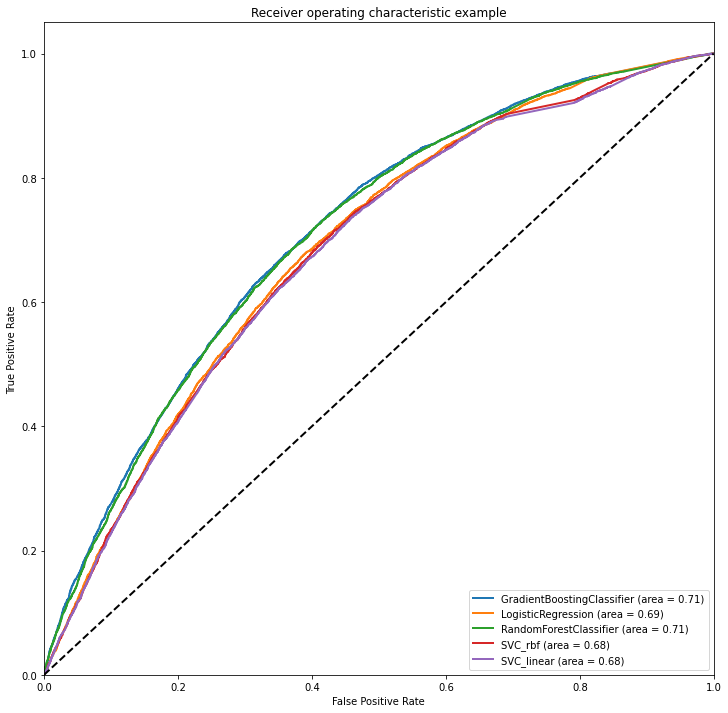

In [22]:
# Compute ROC curve and ROC area for each class
plt.figure(figsize=(12,12))
lw = 2
    
for model in probas:
    proba = probas[model]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(labels_test, proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.plot(fpr[1], tpr[1], #color='darkorange',
             lw=lw, label='{0} (area = {1:.2f})'.format(model,float(roc_auc[1])))
    
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

A comparison of precision-recall curves illustrates the same point.  While the Gradient Boosting and Random Forest classifiers perform better than both SVMs and the Logistic Regression for all threshold values (or lower recall values), the performance advantage increases at higher confidence thresholds.

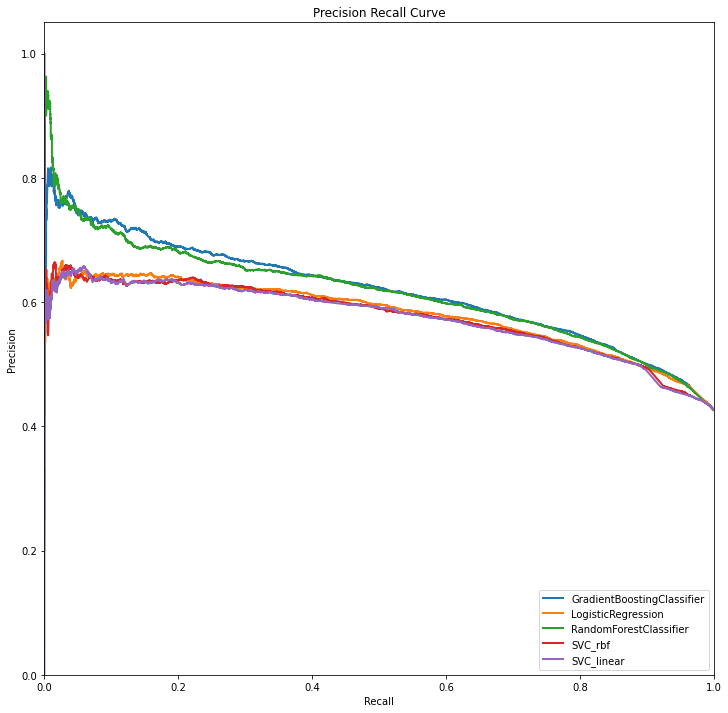

In [23]:
plt.figure(figsize=(12,12))
lw = 2
for model in probas:
    proba = probas[model]
    precision, recall, thresholds = precision_recall_curve(labels_test, proba[:, 1])
    plt.plot(recall, precision, #color='darkorange',
             lw=lw, label='{0}'.format(model))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()

The Negative Predictive Value vs Specificity Curve illustrates that the same relationship does not necessarily hold true for negative predictions.  The Gradient Boosting, Random Forest, and Logistic Regression models all perform relatively similarily at all threshold values, while Both SVM classifiers show a slight dip in performance for high threshold values.

Taken together, the precision-recall and Negative Predictive Value vs Specificity Curves indicate that the Gradient Boosting and Random Forest classifiers primarily outperform other models when predicting positive examples with higher confidence thresholds.  In the context of identifying helpful reader feedback, this means that all 5 models identify unhelpful feedback with similar accuracy.  While the requiring higher confidence in order to make a prediction does decrease the number of unhelpful comments flagged as helpful, classifier choice does not effect this relationship.  Conversely, the Gradient Boosting and Random Forest classifiers both excel when idenifying positive feedback when we require higher confidence to make a prediction.  In this scenario they less frequently flag unhelpful feedback as helpful.

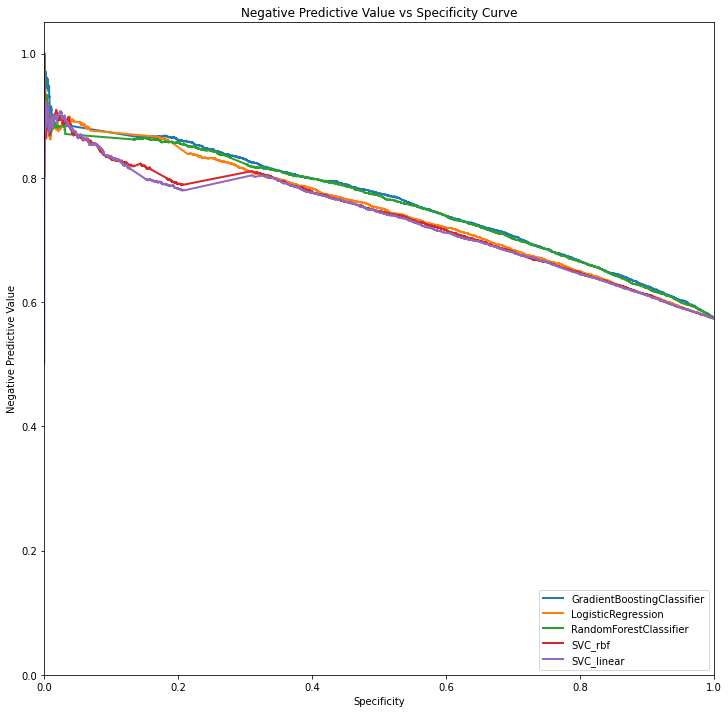

In [24]:
plt.figure(figsize=(12,12))
lw = 2
for model in probas:
    proba = probas[model]
    precision, recall, thresholds = precision_recall_curve(labels_test, proba[:, 0],pos_label=-1)
    plt.plot(recall, precision, #color='darkorange',
             lw=lw, label='{0}'.format(model))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity')
plt.ylabel('Negative Predictive Value')
plt.title('Negative Predictive Value vs Specificity Curve')
plt.legend(loc="lower right")
plt.show()

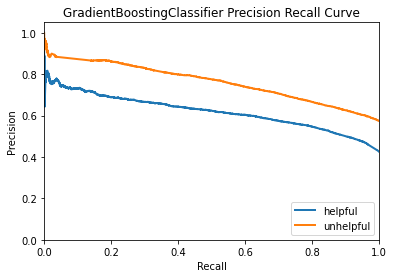

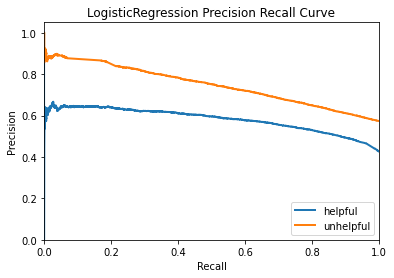

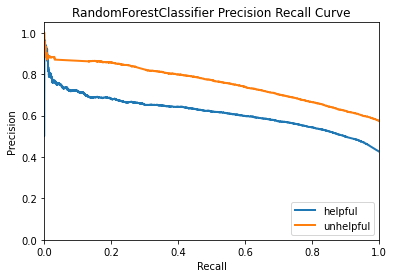

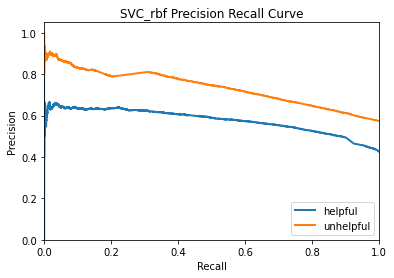

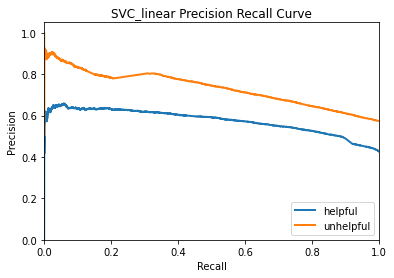

In [72]:
for model in probas:
    plt.figure()
    lw = 2
    for label in [1,-1]:
        if label == -1:
            x=0
            text="unhelpful"

        else:
            x=1
            text="helpful"
        proba = probas[model]
        precision, recall, thresholds = precision_recall_curve(labels_test, proba[:, x],pos_label=label)
        plt.plot(recall, precision, #color='darkorange',
                 lw=lw, label='{0}'.format(text))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('{0} Precision Recall Curve'.format(model))
    plt.legend(loc="lower right")
    plt.show()

In [88]:
threshold_results = pd.DataFrame()

for threshold in np.arange(.5,1,.1):
    t_proba, t_labels, _ = remove_uncertain_predictions(probas['GradientBoostingClassifier'],labels_test,threshold)
    tn, fp, fn, tp = confusion_matrix(proba_to_preds(t_proba),t_labels).ravel()
    
    row = pd.concat([pd.DataFrame({'threshold':[threshold]}), results_to_table(t_proba,t_labels)], axis=1)
    row['work_saved'] = (tp + tn) / len(labels_test)
    row['percent_misclassified'] = (fn + fp) / len(labels_test)
    row['percent_uncertain'] = 1-(len(t_labels)/len(labels_test))
    row['percent_unseen'] = fn / len(labels_test)
    threshold_results = threshold_results.append(row)
    
threshold_results

/home/sjm668/dev/aft-classification/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,accuracy,precision,negative predictive value,recall,f1,roc_auc,work_saved,percent_misclassified,percent_uncertain,percent_unseen
0,0.5,0.659251,0.612059,0.688370,0.547898,0.578204,0.711357,0.659251,0.340749,0.000000,0.148032
0,0.6,0.730130,0.669869,0.755543,0.536096,0.595563,0.746551,0.438439,0.162056,0.399506,0.058804
0,0.7,0.799775,0.746218,0.805447,0.288874,0.416510,0.702323,0.236214,0.059137,0.704649,0.007178
0,0.8,0.858755,0.800000,0.858856,0.009615,0.019002,0.541056,0.119367,0.019633,0.861000,0.000048
0,0.9,0.894737,0.000000,0.894737,0.000000,0.000000,0.643428,0.007273,0.000856,0.991871,0.000000


In [89]:
threshold_results = pd.DataFrame()

for threshold in np.arange(.5,.9,.01):
    t_proba, t_labels, _ = remove_uncertain_predictions(probas['GradientBoostingClassifier'],labels_test,threshold)
    tn, fp, fn, tp = confusion_matrix(proba_to_preds(t_proba),t_labels).ravel()
    
    row = pd.concat([pd.DataFrame({'threshold':[threshold]}), results_to_table(t_proba,t_labels)], axis=1)
    row['work_saved'] = (tp + tn) / len(labels_test)
    row['percent_misclassified'] = (fn + fp) / len(labels_test)
    row['percent_uncertain'] = 1-(len(t_labels)/len(labels_test))
    row['percent_unseen'] = fn / len(labels_test)
    threshold_results = threshold_results.append(row)

/home/sjm668/dev/aft-classification/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


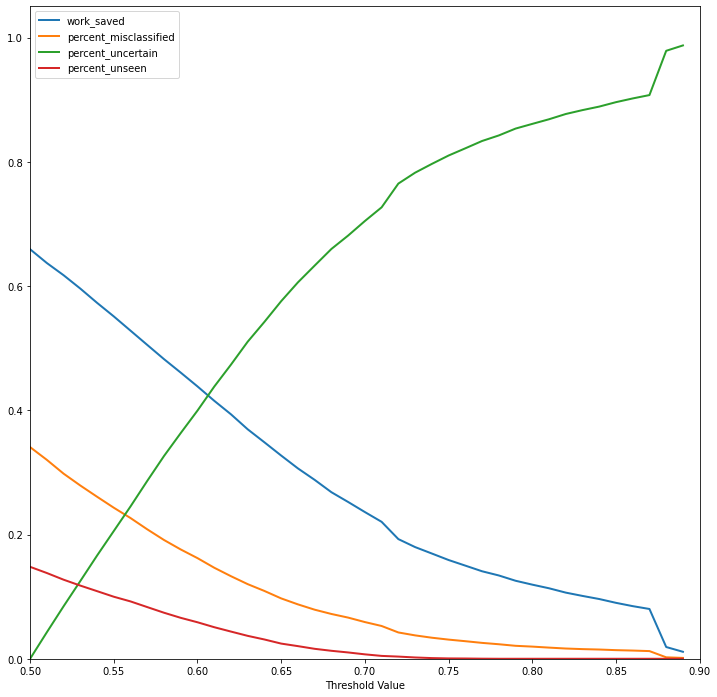

In [91]:
cols = [
    'work_saved',
    'percent_misclassified',
    'percent_uncertain',
    'percent_unseen'
]

plt.figure(figsize=(12,12))
lw = 2
for col in cols:
    plt.plot(threshold_results['threshold'], threshold_results[col], #color='darkorange',
             lw=lw, label='{0}'.format(col))
    
plt.xlim([0.5, 0.9])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold Value')
#plt.ylabel('Precision')
plt.legend(loc="upper left")
plt.show()